# Time Series Analysis

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales.

The data used is the [Superstore Sales Data](https://community.tableau.com/docs/DOC-1236)

In [125]:
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [126]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

sns.set_style('darkgrid')

### Importing data

In [100]:
df = pd.read_excel('Sample - Superstore.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


We begin our analysis forecasting the furniture sales.

In [101]:
furniture = df[df['Category'] == 'Furniture']

In [102]:
furniture['Order Date'].max(), furniture['Order Date'].min()

(Timestamp('2017-12-30 00:00:00'), Timestamp('2014-01-06 00:00:00'))

The data for furniture has a around three years of data.

## Data Preprocessing 

Now first and foremost we will filter out the columns that we simply don't require; Check for missing values and Aggregate Data.

We will only keep two columns for furniture the **Sales** and the **Order Date**

In [103]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

In [104]:
furniture.drop(cols, axis = 1, inplace= True)

In [115]:
furniture.sort_values(by = 'Order Date').head(20)

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939
2014-01-14,61.960
2014-01-16,127.104
2014-01-19,181.470
2014-01-20,1413.510


In [106]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

So we have no missing values, good to know.

In [107]:
furniture = furniture.groupby('Order Date').sum().reset_index()
furniture.set_index('Order Date', inplace= True)

In [108]:
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be difficult to work with so we use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [109]:
temp = furniture['Sales'].resample('MS').mean()
temp.head()

Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

Peek at 2017 furniture sales.

In [119]:
temp['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#### Visualising the sales.

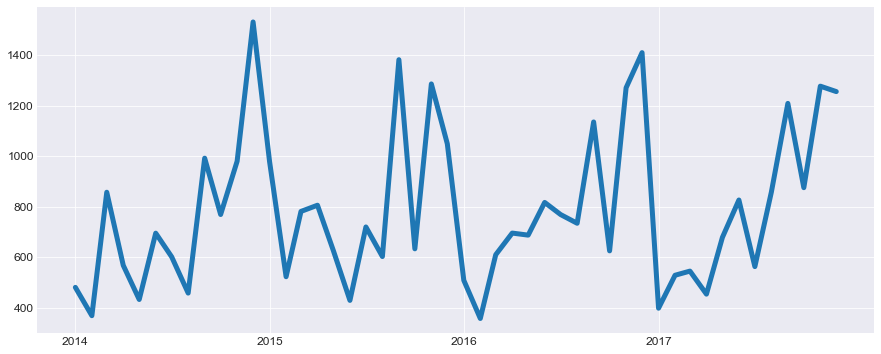

In [138]:
plt.figure(figsize = (15,6))
plt.plot(temp, linewidth = 5)
plt.xticks(['2014', '2015', '2016', '2017'])
plt.show()

There's a very significant sales pattern that we can observe in the plot.  
The sales are generally lower at the beginning of the year but rise towards the end of the year.  
There is always an upward trend within any single year with a couple of low months in the mid of the year.

______

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

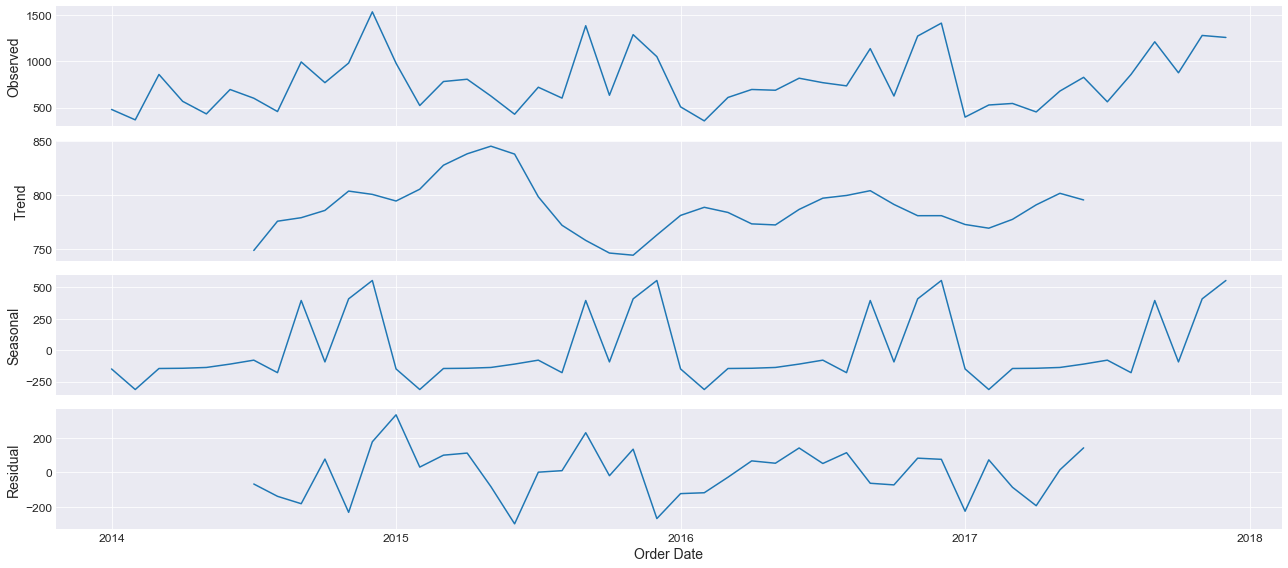

In [153]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
sm.tsa.seasonal_decompose(temp, model= 'additive').plot().show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

_____

## Time Series Forecasting with ARIMA.

ARIMA is one of the most common method of time-series prediction (Autoregressive Integrated Moving Average). 

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data

In [154]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [156]:
list(itertools.product(p, d, q))

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]